In [1]:
# https://tutorials.sciml.ai/html/introduction/03-optimizing_diffeq_code.html
using Latexify
using Plots
using DifferentialEquations 
using ODEInterfaceDiffEq


const π = 0.048                                                                                   # equity premium 
const σ = 0.1789                                                                                    # volatility of equity return (std)
const γ_1 = 4.                                                                               # risk aversion parameter
const γ_2 = 2.
#const γ = 2.0
#const ξ = γ_1 - γ_2
const g = 0.015
const ρ = 0.04                                                                                 # discount rate
const r = 0.025                                                                                   # risk-free rate 
const h = 3.0                                                                                     # habit
const θ = 0.00                                                                                    # habit change of rate 
t_min = 10.0                                                                                       # start    

t_max = 750.0 # solve                                                                             # end 
tspan = (t_min,t_max)                                                                             # fund value interval
step_size = 0.10                                                                                   # saved solutin every step of size

η_γ_1 = (1/γ_1)ρ+(1-1/γ_1)*(r+(1/2)*(π^2/(γ_1*σ^2)))                                                     # calculate eta (c/A) upper bound
η_γ_2 = (1/(γ_2))*ρ+(1-1/(γ_2))*(r+(1/2)*(π^2/((γ_2)*σ^2)))                                        # calculate eta (c/A) lower bound

0.04149853492603235

In [4]:
#Solving simpler CRRA problem numerically
# Upper bound, lowest RRA   
# initial value for the first derivative of the value function
η_γ_1 = (1/γ_1)ρ+(1-1/(γ_1))*(r+(1/2)*(π^2/((γ_1)*σ^2)))  
x₀_γ_1 = η_γ_1^(-(γ_1))*(t_min^(1-(γ_1))/(1-(γ_1)))                                                  # initial value for the value function
y₀_γ_1 = η_γ_1^(-(γ_1))*t_min^(-(γ_1))  
u₀_γ_1 = [x₀_γ_1, y₀_γ_1]                                                                                  # true initial state vector

function c_γ_1(V_a)
    V_a^(-1/(γ_1)) 
end

function SecendDerivative_y(V,V_a,T)
    (0.5*V_a^2*(π/σ)^2)/(((γ_1)/(1-(γ_1)))*V_a^(1-1/(γ_1))-ρ*V+r*T*V_a) 
end

"""
function nohabits1_γ_1!(du,u,p,t)
    V = u[1]
    V_a = u[2]
    du[1] = V_a                                                                                   # the first derivative of the value (dx) function equals y 
    du[2] = (0.5*V_a^2*(μ/σ)^2)/(((γ_1)/(1-(γ_1)))*V_a^(1-1/(γ_1)-ρ*V+r*t*V_a)                   # equation 12a from the notes
end
"""
function nohabits1_γ_1!(du,u,p,t)
    V = u[1]
    V_a = u[2]
    du[1] = V_a                                                                                     # the first derivative of the value (dx) function equals y 
    du[2] = (0.5*V_a^2*(π/σ)^2)/(((γ_1)/(1-(γ_1)))*max(V_a,0)^(1-1/(γ_1))-ρ*V+r*t*V_a)              # equation 12a from the notes
end

prob_γ_1 = ODEProblem(nohabits1_γ_1!,u₀_γ_1,tspan,maxiters=10e4)                                               # define the problem 
@time sol_RRA_γ_1 = solve(prob_γ_1,reltol=1e-12,abstol=1e-12, saveat=step_size)                                 # solve the problem 

V_γ_1_num = [i[1] for i = sol_RRA_γ_1.u]
V_a_γ_1_num = [i[2] for i = sol_RRA_γ_1.u]
#V_aa_y_num = [SecendDerivative_y(sol_RRA_y[1,Int(round(((t-t_min)/step_size+2-t_min), digits=1))],sol_RRA_y[2,Int(round(((t-t_min)/step_size+2-t_min), digits=1))],t) for t = sol_RRA_y.t]
V_aa_γ_1_num = [SecendDerivative_y(V_γ_1_num[i], V_a_γ_1_num[i], sol_RRA_γ_1.t[i]) for i = range(1,stop =length(sol_RRA_γ_1.t))]
c_γ_1_num = [c_γ_1(i[2]) for i = sol_RRA_γ_1.u]
#ω_γ_1_num = [-V_a_y_num[Int(round(((t-t_min)/step_size+2-t_min), digits=1))]/(V_aa_y_num[Int(round(((t-t_min)/step_size+2-t_min), digits=1))]*t)*(μ/σ^2) for t = sol_RRA_y.t]
ω_γ_1_num = [-V_a_γ_1_num[i]/(V_aa_γ_1_num[i]*sol_RRA_γ_1.t[i])*(π/σ^2) for i = range(1,stop =length(sol_RRA_γ_1.t))]
t = sol_RRA_γ_1.t
println("")

 24.010207 seconds (17.08 M allocations: 1.036 GiB, 1.45% gc time, 99.85% compilation time)



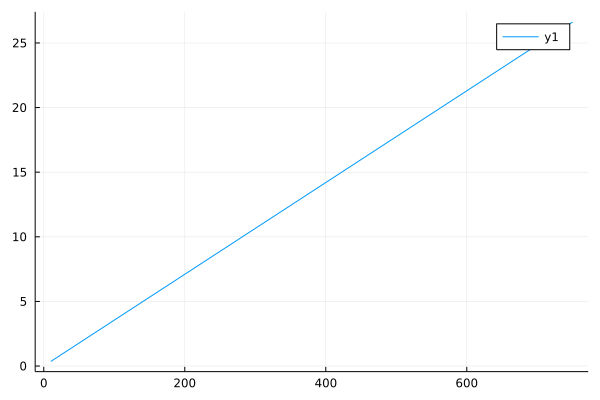

In [6]:
#optimal consumption as function of wealth
plot(t, c_γ_1_num)

In [7]:
η_γ_1

0.03549890119452427

In [8]:
#Solving simpler CRRA problem numerically
# lower bound, highest RRA   
η_γ_2 = (1/γ_2)ρ+(1-1/(γ_2))*(r+(1/2)*(π^2/((γ_2)*σ^2)))  
x₀_γ_2 = η_γ_2^(-(γ_2))*(t_min^(1-(γ_2))/(1-(γ_2)))                                                  # initial value for the value function
y₀_γ_2 = η_γ_2^(-(γ_2))*t_min^(-(γ_2))  
u₀_γ_2 = [x₀_γ_2, y₀_γ_2]  

function nohabits1_γ_2!(du,u,p,t)
    V = u[1]
    V_a = u[2]
    du[1] = V_a                                                                                     # the first derivative of the value (dx) function equals y 
    du[2] = (0.5*V_a^2*(π/σ)^2)/(((γ_2)/(1-(γ_2)))*max(V_a,0)^(1-1/(γ_2))-ρ*V+r*t*V_a)              # equation 12a from the notes
end

prob_γ_2 = ODEProblem(nohabits1_γ_2!,u₀_γ_2,tspan,maxiters=10e4)                                               # define the problem 
@time sol_RRA_γ_2 = solve(prob_γ_2,reltol=1e-12,abstol=1e-12, saveat=step_size)   
sol_RRA_γ_2[1]

 17.520768 seconds (5.51 M allocations: 344.872 MiB, 0.68% gc time, 99.96% compilation time)


2-element Vector{Float64}:
 -58.067679472400826
   5.806767947240083

In [9]:
η_γ_2

0.04149853492603235

In [10]:
"""
Comparing analytical solution and numerical 
"""


V_γ_1_true = [η_γ_1^-γ_1*(i^(1-γ_1))/(1-γ_1) for i = sol_RRA_γ_1.t]
V_a_γ_1_true = [η_γ_1^-γ_1*i^-γ_1 for i = sol_RRA_γ_1.t]
V_aa_γ_1_true = [-γ_1*η_γ_1^-γ_1*i^-(γ_1+1) for i = sol_RRA_γ_1.t]
c_γ_1_true = [η_γ_1*i for i = sol_RRA_γ_1.t]
ω_γ_1_true = [π/(γ_1*σ^2) for i = sol_RRA_γ_1.t]

#NB: using t values from numerical solution for γ_1
V_γ_2_true = [η_γ_2^-(γ_2)*(i^(1-γ_2))/(1-γ_2) for i = sol_RRA_γ_1.t]
V_a_γ_2_true = [η_γ_2^-(γ_2)*i^-(γ_2) for i = sol_RRA_γ_1.t]
V_aa_γ_2_true = [-(γ_2)*η_γ_2^-(γ_2)*i^-(γ_2+1) for i = sol_RRA_γ_1.t]
c_γ_2_true = [η_γ_2*i for i = sol_RRA_γ_1.t]
ω_γ_2_true = [π/((γ_2)*σ^2) for i = sol_RRA_γ_1.t]



7401-element Vector{Float64}:
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 ⋮
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964
 0.7498779105026964

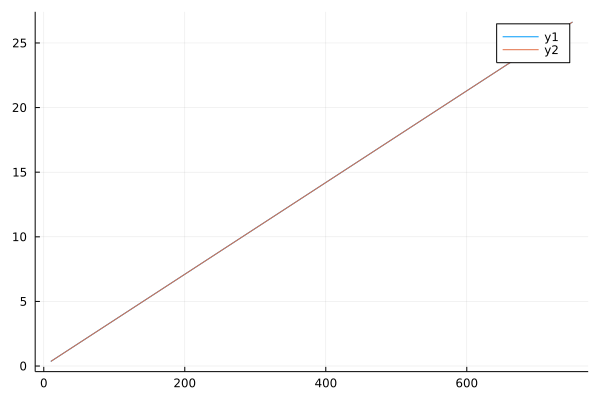

In [11]:
#optimal consumption as function of wealth
plot(sol_RRA_γ_1.t, [c_γ_1_num, c_γ_1_true])

In [12]:
function softhabits!(V,V_A)
    c = 
    utility = 0
    if h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1)) < h
        c = h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1))
        utility = h^(1-(γ_2/γ_1))*max(V_A,0)^(1-1/(γ_1))/(1-γ_1)
    else
        c = V_A^(-1/γ_2)
        utility = ((1-γ_1)*V_A^(1-(1/γ_2))+(γ_1-γ_2)*h^(1-γ_2))/((1-γ_1)*(1-γ_2))
    end
    du[2] = (1/2*V_A^2*(π/σ)^2)/(utility - (ρ-(1-γ_2)*g)*V+max(V_A,0)*((r-g)*t-c))
end

softhabits! (generic function with 1 method)

In [13]:
"""
defining the functions with habits
"""

ex5 = :(du[1] = u[2])
display(latexify(ex5))

ex5 = :(If, h^(ξ/(γ_2))*u[2]^(-1/(γ_2)) < h)
display(latexify(ex5))

ex6 = :(du[2] = 1/2*u[2]^2*(μ/σ)^2/(((h^ξ)*(h^(ξ/(γ_2))*u[2]^-(1/(γ_2)))^(1-γ_1-ξ))/(1-γ_1-ξ)-ρ*u[1]+r*t*u[2]-h^(ξ/(γ_2))*u[2]^(1-1/(γ_2))))
display(latexify(ex6))

ex7 = :(Else, du[2]  = 1/2*u[2]^2*(μ/σ)^2/(((1-γ_1-ξ)*u[2]^(1-1/γ_1)+ξ*h^(1-γ_1))/((1-γ_1)*(1-γ_1-ξ))-ρ*u[1]+r*t*u[2]-u[2]^(1-1/γ_1)))
display(latexify(ex7))

function softhabits!(du,u,p,t)
    V = u[1]
    V_A = u[2]
    du[1] = V_A
    
    c = 0
    utility = 0
    if h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1)) < h
        c = h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1))
        utility = h^(1-(γ_2/γ_1))*max(V_A,0)^(1-1/(γ_1))/(1-γ_1)
    else
        c = V_A^(-1/γ_2)
        utility = ((1-γ_1)*V_A^(1-(1/γ_2))+(γ_1-γ_2)*h^(1-γ_2))/((1-γ_1)*(1-γ_2))
    end
    du[2] = (1/2*V_A^2*(π/σ)^2)/(utility - (ρ-(1-γ_2)*g)*V+max(V_A,0)*((r-g)*t-c))
end

"""
function softhabits!(du,u,p,t)
    du[1] = u[2]
    if h^(ξ/(γ_2))*u[2]^(-1/(γ_2)) < h
        du[2] = 1/2*u[2]^2*(μ/σ)^2/(((h^ξ)*(h^(ξ/(γ_2))*u[2]^-(1/(γ_2)))^(1-γ_1-ξ))/(1-γ_1-ξ)-ρ*u[1]+r*t*u[2]-h^(ξ/(γ_2))*u[2]^(1-1/(γ_2)))
    else
        du[2]  = 1/2*u[2]^2*(μ/σ)^2/(((1-γ_1-ξ)*u[2]^(1-1/γ_1)+ξ*h^(1-γ_1))/((1-γ_1)*(1-γ_1-ξ))-ρ*u[1]+r*t*u[2]-u[2]^(1-1/γ_1))
    end
end
"""



function c_optimal(V_A)
    if h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1)) < h
        h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1))
    else
        V_A^(-1/γ_2)
    end 
end


function SecendDerivative(V,V_A,T,h)
    if h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1)) < h
        c = h^(1-(γ_2/γ_1))*max(V_A,0)^(-1/(γ_1))
        utility = h^(1-(γ_2/γ_1))*max(V_A,0)^(1-1/(γ_1))/(1-γ_1)
        (1/2*V_A^2*(π/σ)^2)/(utility - (ρ-(1-γ_2)*g)*V+max(V_A,0)*((r-g)*T-c))
    else
        c = V_A^(-1/γ_2)
        utility = ((1-γ_1)*V_A^(1-(1/γ_2))+(γ_1-γ_2)*h^(1-γ_2))/((1-γ_1)*(1-γ_2))
        (1/2*V_A^2*(π/σ)^2)/(utility - (ρ-(1-γ_2)*g)*V+max(V_A,0)*((r-g)*T-c))
    end
end

L"$\mathrm{du}\left[1\right] = u\left[2\right]$"

L"$If, \left( h^{\frac{\xi}{\gamma_{2}}} \cdot \left( u\left[2\right] \right)^{\frac{-1}{\gamma_{2}}} < h \right)$"

L"$\mathrm{du}\left[2\right] = \frac{\frac{1}{2} \cdot \left( u\left[2\right] \right)^{2} \cdot \left( \frac{\mu}{\sigma} \right)^{2}}{\frac{h^{\xi} \cdot \left( h^{\frac{\xi}{\gamma_{2}}} \cdot \left( u\left[2\right] \right)^{ - \frac{1}{\gamma_{2}}} \right)^{1 - \gamma_{1} - \xi}}{1 - \gamma_{1} - \xi} - \rho \cdot u\left[1\right] + r \cdot t \cdot u\left[2\right] - h^{\frac{\xi}{\gamma_{2}}} \cdot \left( u\left[2\right] \right)^{1 - \frac{1}{\gamma_{2}}}}$"

L"$Else, \mathrm{du}\left[2\right] = \frac{\frac{1}{2} \cdot \left( u\left[2\right] \right)^{2} \cdot \left( \frac{\mu}{\sigma} \right)^{2}}{\frac{\left( 1 - \gamma_{1} - \xi \right) \cdot \left( u\left[2\right] \right)^{1 - \frac{1}{\gamma_{1}}} + \xi \cdot h^{1 - \gamma_{1}}}{\left( 1 - \gamma_{1} \right) \cdot \left( 1 - \gamma_{1} - \xi \right)} - \rho \cdot u\left[1\right] + r \cdot t \cdot u\left[2\right] - \left( u\left[2\right] \right)^{1 - \frac{1}{\gamma_{1}}}}$"

SecendDerivative (generic function with 1 method)

In [14]:
#defining and solving soft habits
eta = 0.027998901187452113
c_init = t_min*eta
V_a_init = h^(γ_1-γ_2)*(eta*t_min)^(-γ_1)
ω_γ_1_init = π/((γ_1)*σ^2) 
V_aa_init = - (V_a_init/(ω_γ_1_init*t_min))*(π/σ^2)
utility = (h^(1-(γ_2/γ_1))*max(V_a_init,0)^(1-1/(γ_1)))/(1-γ_1)
V_init = (utility + V_a_init*((r-g)*t_min-c_init)-(1/2)*((V_a_init^2)/V_aa_init)*(π/σ)^2)/(ρ-g*(1-γ_2))
guess = [V_init, V_a_init]

prob = ODEProblem(softhabits!, guess,[t_min,t_max],maxiters=10e6)                                                                   # define the problem, update inital conditions  
@time sol = solve(prob,Rosenbrock23(),reltol=1e-12,abstol=1e-12, saveat=step_size, isoutofdomain=(u,p,t) -> u[2]<0)
V = [u[1] for u = sol.u]
V_A = [u[2] for u = sol.u]
t = sol.t
V_AA = [SecendDerivative(V[i], V_A[i], t[i], h) for i = range(1,stop =length(sol.u))]
c = c_optimal.(V_A)
ω = [-V_A[i]/(V_AA[i]*t[i])*(π/σ^2) for i = range(1,stop =length(sol.u))]

 10.353231 seconds (20.68 M allocations: 1.294 GiB, 3.99% gc time, 68.26% compilation time)


7401-element Vector{Float64}:
 0.37493895525134796
 0.3749389552635144
 0.37493895527642335
 0.3749389552901573
 0.3749389553047495
 0.3749389553202768
 0.3749389553367925
 0.3749389553543772
 0.37493895537309146
 0.3749389553930132
 0.3749389554142065
 0.3749389554367606
 0.37493895546076206
 ⋮
 0.7338470498325219
 0.7338568810657308
 0.7338667129352433
 0.7338765454420217
 0.7338863785870303
 0.7338962123712308
 0.7339060467955831
 0.7339158818610493
 0.7339257175685926
 0.7339355539191725
 0.7339453909137481
 0.7339552285532264

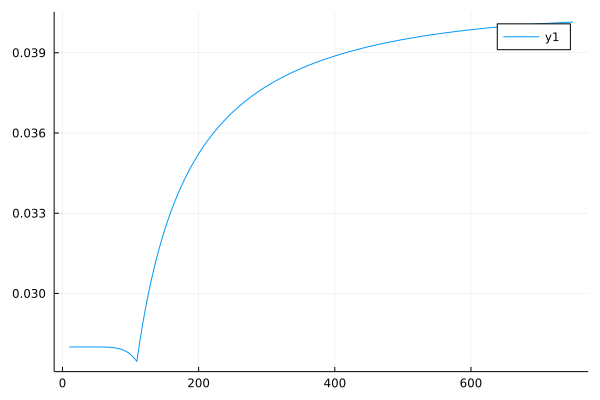

In [15]:
#optimal consumption/wealth as function of wealth - soft habits
plot(sol.t, c./sol.t)